In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import (
    permutation_test, 
    ttest_ind, mannwhitneyu, 
    skew, kurtosis,
    fisher_exact, chi2_contingency,
    pearsonr, spearmanr, kendalltau,
    shapiro, normaltest,
    binomtest, binom,
    zscore, iqr,
    rankdata,
    bayes_mvs, bootstrap
    )

from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

gross_summ = X[:, 0]*50 + np.random.normal(0, 15, size=10000) 
gross_summ += np.where(y==1, 25, 0)

conversion = np.zeros(10000, dtype=int)
conversion[y == 0] = np.random.binomial(1, 0.3, size=(y==0).sum())
conversion[y == 1] = np.random.binomial(1, 0.32, size=(y==1).sum())

df = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(gross_summ),
    'target': y,
    'conversion': conversion
})

df.head()

,user_id,gross_summ,target,conversion
0,4,56.746809,0,1
1,182,12.017073,0,1
2,180,20.364494,1,1
3,158,27.444046,0,1
4,73,61.200665,1,0


# AB

## універсальна

### permutation_test

Пермутаційний тест — це непараметричний спосіб перевірити, чи різниця між двома групами не є випадковою.

In [3]:
res = permutation_test(
    (df.loc[df['target']==0, 'gross_summ'], 
     df.loc[df['target']==1, 'gross_summ']),
    statistic=lambda x, y: y.mean() - x.mean(),
    n_resamples=100,
    alternative='two-sided'
)

res.statistic, res.pvalue

(1.8693586604242327, 0.0594059405940594)

In [4]:
res = permutation_test(
    (df.loc[df['target']==0, 'conversion'], 
     df.loc[df['target']==1, 'conversion']),
    statistic=lambda x, y: y.mean() - x.mean(),
    n_resamples=100,
    alternative='two-sided'
)

res.statistic, res.pvalue

(0.021399999999999975, 0.07920792079207921)

In [5]:
def percentile_75_diff(a, b):
    return np.percentile(b, 75) - np.percentile(a, 75)

res = permutation_test(
    (df.loc[df['target']==0, 'gross_summ'], 
     df.loc[df['target']==1, 'gross_summ']),
    statistic=percentile_75_diff,
    n_resamples=100,
)
res.statistic, res.pvalue

(3.9963367172369857, 0.019801980198019802)

In [6]:
# --- Permutation test ---
control = df.loc[df['target']==0, 'gross_summ']
target = df.loc[df['target']==1, 'gross_summ']
n_iter = 1000

observed = np.mean(target) - np.mean(control)
combined = np.concatenate([control, target])
n_tr = len(control)
perm_diffs = []

for _ in range(n_iter):
    np.random.shuffle(combined)
    tr_perm = combined[:n_tr]
    co_perm = combined[n_tr:]
    perm_diffs.append(tr_perm.mean() - co_perm.mean())

perm_diffs = np.array(perm_diffs)
perm_ci_lower, perm_ci_upper = np.percentile(perm_diffs, [2.5, 97.5])
p_perm = (np.abs(perm_diffs) >= np.abs(observed)).mean()

print(f"Observed Difference: {observed:.4f}")
print(f"95% Permutation CI: [{perm_ci_lower:.4f}, {perm_ci_upper:.4f}]")
print(f"Permutation p-value: {p_perm:.4f}")

Observed Difference: 1.8694
95% Permutation CI: [-1.8972, 1.7704]
Permutation p-value: 0.0460


## числові

### ttest_ind

t-test (independent samples) – перевіряє, чи відрізняються середні двох незалежних груп.
Передбачає, що дані приблизно нормальні; може враховувати рівність або нерівність дисперсій (Welch’s t-test).
Повертає t-статистику (наскільки сильно середні відрізняються від нульової гіпотези) та p-value (значущість).

In [7]:
ttest_ind(
    df.loc[df['target']==0, 'gross_summ'], 
    df.loc[df['target']==1, 'gross_summ'],
    equal_var=False
)

TtestResult(statistic=-2.0987511535116945, pvalue=0.03586392947944031, df=9970.691466521317)

### mannwhitneyu

Mann–Whitney U test – перевіряє, чи одна група схильна мати більші значення за іншу без припущення про нормальний розподіл.
Працює з рангами всіх спостережень, а не безпосередньо з числами.
Не потребує рівності дисперсій або нормальності.
Повертає U-статистику (сума рангових перемог однієї групи над іншою) та p-value (значущість різниці).

In [8]:
mannwhitneyu(
    df.loc[df['target']==0, 'gross_summ'], 
    df.loc[df['target']==1, 'gross_summ'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=12306530.0, pvalue=0.18013840725083596)

## бінарні

### fisher_exact

Fisher’s exact test – перевіряє, чи бінарна подія (conversion) залежить від групи (A/B).
Використовує 2×2 таблицю; фіксує маргінали — суму рядків і стовпців, щоб зберегти загальні підсумки груп і конверсій.
Обчислює точну ймовірність спостережуваних або більш екстремальних результатів.
Повертає statistic (асоціація) та p-value (значущість).

In [9]:
fisher_exact(
    pd.crosstab(df['conversion'], df['target'])
)

SignificanceResult(statistic=1.1052753373139874, pvalue=0.021890341995649203)

### chi2_contingency

Chi-square test of independence – перевіряє, чи дві категоріальні змінні незалежні.
Використовує контингентну таблицю (будь-якого розміру, не лише 2×2).
Порівнює спостережувані частоти з очікуваними при незалежності.
Повертає χ²-статистику (розбіжність між спостережуваними та очікуваними), p-value (значущість), degrees of freedom і очікувані частоти.

In [10]:
chi2_contingency(
    pd.crosstab(df['conversion'], df['target'])
)

Chi2ContingencyResult(statistic=5.253855535525504, pvalue=0.021898198120573198, dof=1, expected_freq=array([[3450.5, 3450.5],
       [1549.5, 1549.5]]))

# оцінка даних

### skew

Skewness (асиметрія) – показує, наскільки розподіл даних зрушений відносно середнього.
- skew(x) > 0 → позитивна асиметрія (довгий правий хвіст)
- skew(x) < 0 → негативна асиметрія (довгий лівий хвіст)
- skew(x) ≈ 0 → симетричний розподіл

In [11]:
data_normal = np.random.normal(loc=50, scale=10, size=1000)
data_right_skew = np.random.exponential(scale=12, size=1000)
data_left_skew = -np.random.exponential(scale=12, size=1000) + 80

df_skew = pd.DataFrame({
    'value': np.concatenate([data_normal, data_right_skew, data_left_skew]),
    'type': ['normal']*1000 + ['right_skew']*1000 + ['left_skew']*1000
})

df_skew.groupby('type')['value'].apply(skew)

type
left_skew    -2.102914
normal        0.162600
right_skew    2.155766
Name: value, dtype: float64

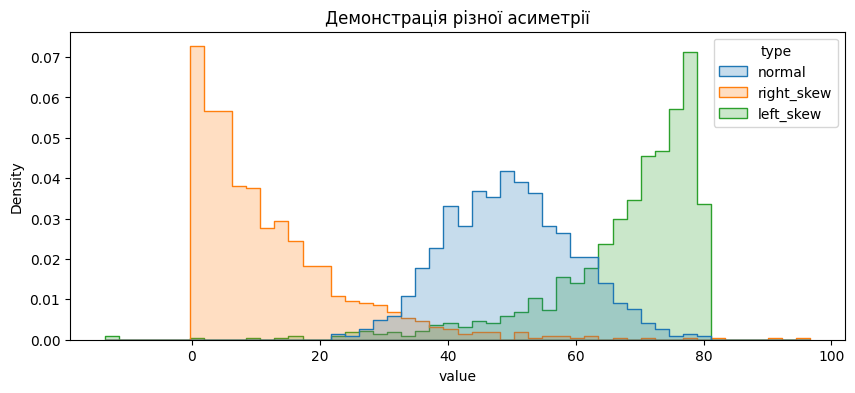

In [12]:
plt.figure(figsize=(10,4))
sns.histplot(df_skew, x='value', hue='type', element='step', stat='density', common_norm=False, bins=50)
plt.title("Демонстрація різної асиметрії")
plt.show()


### kurtosis

Kurtosis (куртозис) – показує, наскільки розподіл даних гострий або плаский порівняно з нормальним.
- kurtosis(x) > 0 → leptokurtic (гострий пік, важкі хвости)
- kurtosis(x) < 0 → platykurtic (плаский розподіл, легкі хвости)
- kurtosis(x) ≈ 0 → mesokurtic (як нормальний розподіл)

In [13]:
data_normal = np.random.normal(loc=50, scale=10, size=1000)
data_lepto = np.concatenate([np.random.normal(50, 5, 950), np.random.normal(50, 50, 50)])
data_platy = np.random.uniform(20, 80, 1000)

df_kurtosis = pd.DataFrame({
    'value': np.concatenate([data_normal, data_lepto, data_platy]),
    'type': ['normal']*1000 + ['leptokurtic']*1000 + ['platykurtic']*1000
})

df_kurtosis.groupby('type')['value'].apply(lambda x: kurtosis(x))

type
leptokurtic    34.261675
normal          0.088135
platykurtic    -1.279169
Name: value, dtype: float64

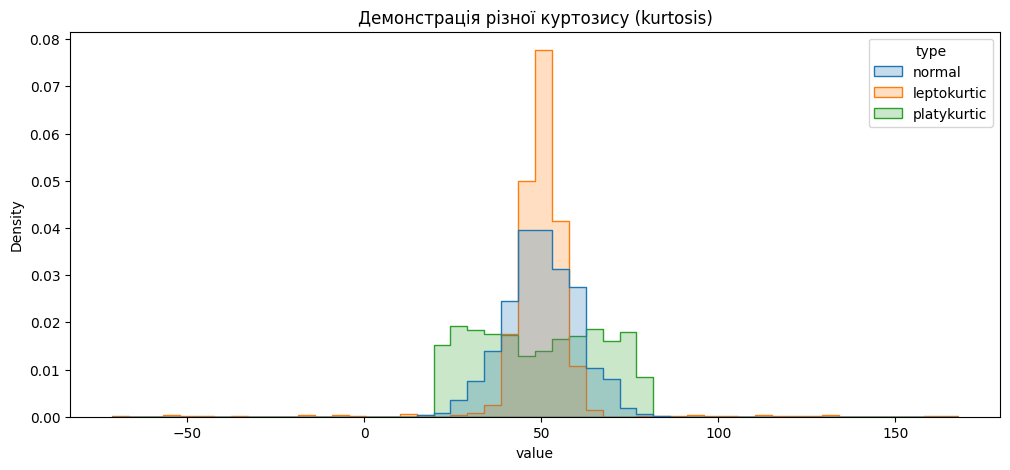

In [14]:
plt.figure(figsize=(12,5))
sns.histplot(df_kurtosis, x='value', hue='type', element='step', stat='density', common_norm=False, bins=50)
plt.title("Демонстрація різної куртозису (kurtosis)")
plt.show()

### bayes_mvs

bayes_mvs(x, alpha=0.95) – Байєсівська оцінка параметрів розподілу (mean, variance, стандартне відхилення) з довірчими інтервалами.
- Працює як “Bayesian analog” до класичних CI, використовуючи нормальний-невідому-дисперсію припущення.
- Повертає тюпли для mean, variance, std, кожен з point estimate і credible interval.
- alpha → рівень довіри (наприклад, 0.95 → 95% CI)
- Підходить для оцінки середнього і дисперсії з невеликою або шумною вибіркою

In [15]:
bayes_mvs(
    df.loc[df['target']==0, 'gross_summ'], 
    alpha=0.95
)

(Mean(statistic=61.74837912840401, minmax=(60.5468095526896, 62.94994870411842)),
 Variance(statistic=1879.1942236954958, minmax=(1805.5311637275183, 1952.8572836634733)),
 Std_dev(statistic=43.349673859159495, minmax=(42.5000358641044, 44.19931185421459)))

### bootstrap

bootstrap(data, statistic, confidence_level=0.95, n_resamples=10000, method='basic') – оцінка довірчих інтервалів статистики методом повторного семплування (bootstrap).
- data – кортеж масивів ((x,) для однієї змінної).
- statistic – функція для обчислення (наприклад, np.mean, np.median або кастомна).
- confidence_level – рівень довіри CI (0.95 → 95% CI).
- n_resamples – кількість повторних семплів (чим більше, тим точніше CI).
- method – метод побудови CI:
    - 'basic' → дзеркальний CI щодо point estimate (класичний базовий bootstrap)
    - 'percentile' → просто percentiles з повторних семплів
    - 'BCa' → bias-corrected & accelerated, коригує на зсув і асиметрію (найточніший для малих або skewed вибірок)
    
-Повертає: об’єкт з confidence_interval → нижня та верхня межа CI для обраної статистики.

In [33]:
res = bootstrap((df['gross_summ'].values,), np.mean, confidence_level=0.95)
res.confidence_interval

ConfidenceInterval(low=61.81773002135282, high=63.55771676912167)

In [37]:
res.bootstrap_distribution

array([62.33671655, 62.33353802, 62.27532573, ..., 62.63391225,
       63.17111971, 63.31620769])

In [17]:
res = bootstrap(
    (df[df['target']==0]['gross_summ'].values, df[df['target']==1]['gross_summ'].values), 
    statistic=lambda x, y: y.mean() - x.mean(),
    n_resamples=1000,
    confidence_level=0.95,
    batch=100
)
res.confidence_interval

ConfidenceInterval(low=0.05255568892555644, high=3.691822325917541)

# кореляція

### pearson

pearsonr(x, y) – перевіряє лінійну залежність між двома числовими змінними.
- r ∈ [-1, 1] → сила і напрямок лінійної кореляції
- p-value → значущість кореляції
- Підходить для приблизно нормальних даних та лінійних зв’язків

In [18]:
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 0.5 * x + np.random.normal(0, 1, 100)

r, p = pearsonr(x, y)
print("Pearson r:", r)
print("p-value:", p)

Pearson r: 0.32438461951463937
p-value: 0.0009927493337307963


### spearmanr

spearmanr(x, y) – перевіряє монотонну залежність (не обов’язково лінійну) між змінними.
- rho ∈ [-1, 1] → кореляція між рангами
- p-value → значущість
- Підходить для нестандартних або skewed даних, або коли є нелінійна монотонна залежність

In [19]:
x = np.arange(1, 101)
y = x**2 + np.random.normal(0, 50, 100)

rho, p = spearmanr(x, y)
print("Spearman rho:", rho)
print("p-value:", p)

Spearman rho: 0.999135913591359
p-value: 3.4527277149437393e-137


### kendalltau

kendalltau(x, y) – ранговий тест для порядкових залежностей, більш стійкий до невеликих вибірок і вибивачів.
- tau ∈ [-1, 1] → сила порядкової залежності
- p-value → значущість
- Добре підходить для малих вибірок або багато tied values

In [20]:
x = [12, 2, 1, 12, 2]
y = [1, 4, 7, 1, 0]

tau, p = kendalltau(x, y)
print("Kendall tau:", tau)
print("p-value:", p)

Kendall tau: -0.4714045207910316
p-value: 0.28274545993277467


# нормальність

### shapiro

shapiro(x) – перевіряє, чи дані приблизно нормально розподілені.
- stat → тестова статистика
- p-value → значущість
- p > 0.05 → немає підстав відхиляти нормальність
- Добре для малих і середніх вибірок

In [21]:
np.random.seed(42)
data = np.random.normal(0, 1, 100)

stat, p = shapiro(data)
print("Shapiro-Wilk stat:", stat)
print("p-value:", p)

Shapiro-Wilk stat: 0.9898831844329834
p-value: 0.6551515460014343


### normaltest

normaltest(x) – перевіряє нормальність за допомогою комбінації асиметрії (skew) та куртозису (kurtosis).
- p > 0.05 → немає підстав відхиляти нормальність
- Підходить для середніх і великих вибірок

In [22]:
data = np.random.normal(0, 1, 100)

stat, p = normaltest(data)
print("D’Agostino K² stat:", stat)
print("p-value:", p)

D’Agostino K² stat: 2.6599721025976133
p-value: 0.2644809504398436


### binomtest

binom_test(k, n, p, alternative) – перевіряє, чи частота успіхів відповідає очікуваній ймовірності.
- k → кількість успіхів
- n → загальна кількість спроб
- p → очікувана ймовірність успіху
- alternative → 'two-sided', 'greater', 'less'
- Повертає p-value > 0.05, немає підстав відхиляти нульову гіпотезу, тобто частота успіхів не відрізняється від очікуваної
- Ідеально для малих вибірок або простих A/B тестів із бінарною подією

In [23]:
successes = 55
trials = 100
p_expected = 0.5

p = binomtest(successes, n=trials, p=p_expected, alternative='two-sided')
print("Binomial test p-value:", p.pvalue)

Binomial test p-value: 0.36820161732669565


# вірогідності

### binom

In [24]:
def binom_probability(n: int, p: float, m1: int, m2: int) -> float:
    """
    Ймовірність отримати кількість успіхів між m1 і m2 включно
    при n спробах з ймовірністю успіху p.

    Args:
        n (int): Кількість спроб
        p (float): Ймовірність успіху
        m1 (int): Нижня межа успіхів
        m2 (int): Верхня межа успіхів

    Returns:
        float: Ймовірність (округлена до 2 знаків)
    """
    probability = binom.cdf(m2, n, p) - binom.cdf(m1 - 1, n, p)
    return round(probability, 2)

ймовірність від 55 до 60 успіхів з 100 спроб при p=0.5

In [25]:
print(binom_probability(100, 0.5, 50, 55))  

0.4


ймовірність рівно 10 успіхів з 50 при p=0.2

In [26]:
binom.pmf(10, 50, 0.2)  

0.13981900517431578

# zscore & IQR

### zscore

zscore(x) – стандартизує дані, переводячи кожне значення у кількість стандартних відхилень від середнього.
- Підходить для нормалізації перед моделями, виявлення аутлайєрів або порівняння змінних у різних шкалах.

In [27]:
data = np.array([10, 15, 20, 25, 30])
z = zscore(data)
print("z-scores:", z)

z-scores: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]


zscore використовуєтся в StandardScaler

In [28]:
from sklearn.preprocessing import StandardScaler

data = np.array([[10, 2000],
                 [20, 5000],
                 [30, 8000]])

# zscore
z1 = zscore(data, axis=0)
print("zscore:\n", z1)

# StandardScaler
scaler = StandardScaler()
z2 = scaler.fit_transform(data)
print("StandardScaler:\n", z2)

zscore:
 [[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]
StandardScaler:
 [[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]


In [29]:
def detect_outliers_zscore(column: pd.Series, threshold: float = 3) -> list:
    """
    Detect outliers in a column of a dataframe using Z-score method.
    
    :param column: column of a dataframe (pd.Series)
    :param threshold: threshold for outlier detection (default is 3)
    :return: list of indices of outliers
    """
    z_scores = zscore(column, nan_policy='omit')  
    outlier_indices = column[abs(z_scores) > threshold].index.tolist()
    
    return outlier_indices

outliers = detect_outliers_zscore(df['gross_summ'], threshold=3)
print("Outlier indices:", outliers)

Outlier indices: [135, 319, 561, 665, 924, 952, 995, 1037, 1052, 1118, 1563, 1838, 2019, 2235, 2312, 2888, 3372, 3464, 3518, 3544, 3568, 3967, 3981, 4057, 4311, 4340, 4348, 4353, 4394, 4522, 4628, 4976, 5347, 5424, 5433, 5498, 5658, 5711, 5870, 6031, 6260, 6274, 6546, 6691, 6961, 7003, 7030, 7283, 7284, 7385, 7858, 8384, 8421, 8732, 8766, 8937, 9325, 9344, 9415, 9448, 9579, 9598, 9813, 9834, 9873, 9877]


### iqr

iqr(x) – обчислює міжквартильний розмах, тобто різницю між 75-м і 25-м процентилем.
- Показує розсіяння «середньої половини» даних, менш чутливий до аутлайєрів, ніж стандартне відхилення.
- Використовується разом із skew та kurtosis для аналізу форми розподілу.

In [30]:
data = [1, 3, 5, 7, 9, 11, 13]
iqr_value = iqr(data)

percentile_25 = np.percentile(data, 25)
percentile_75 = np.percentile(data, 75)
diff = percentile_75 - percentile_25

print("IQR:", iqr_value)
print("IQR (alternative method):", diff)

IQR: 6.0
IQR (alternative method): 6.0


# other

### rankdata

rankdata(x) – перетворює значення у ранги (порядкові місця).
- Використовується для рангових тестів (Spearman, Kendall), або коли важлива порядкова інформація, а не абсолютні значення.
- Tie values отримують середній ранг.

In [31]:
data = [100, 200, 150, 200]
ranks = rankdata(data)
print("Ranks:", ranks)

Ranks: [1.  3.5 2.  3.5]
